In [ ]:
pip install wordcloud

In [ ]:
pip install gensim

In [ ]:
pip install pyLDAvis

In [ ]:
pip install docx2txt

In [23]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


### **데이터 호출 및 전처리**

In [40]:
import pandas as pd
import os
import docx2txt
from tqdm import tqdm 
tqdm.pandas()
df = pd.DataFrame()

# 읽어올 파일폴더 설정 (경로, datatype= 'docx' or 'xlsx', min_text_docx = n 문단최소글자수, min_text_xlsx = n 엑셀 최소 글자수 default == 5)
""" 
def file_process(n, dt='xlsx'):
----------------------------------------------------
n - file num
dt - data type ('xlsx', 'docx') // default == 'xlsx'
----------------------------------------------------

path_list (블로그/유튜브/인스타/트위터) + 보고서
[0~3] - 2020/2021  0:블로그 / 1: 유튜브 / 2: 인스타 / 3: 트위터
[4~7] - 2022       4:블로그 / 5: 유튜브 / 6: 인스타 / 7: 트위터
[8]   - 보고서      8: 보고서

"""

# df = file_process(8, dt='docx')

df_blog = file_process(4)
df_yt = file_process(5)
df_insta = file_process(6)
df_twitter = file_process(7)

df = pd.concat([df, df_blog, df_yt, df_insta, df_twitter], ignore_index=True)
# df.to_excel('소셜미디어_전처리.xlsx', encoding='utf-8-sig')

Tokenization Progress: 100%|████████████████████████████████████████████████████| 4357/4357 [00:00<00:00, 45375.30it/s]


In [138]:
#토큰 확인
import itertools
token_list = df['tokens'].tolist()
token_list = list(itertools.chain(*token_list))
len(token_list)
b = set(token_list)


# list3 = df['title'].tolist()
# c = set(list3)
# print(len(c))

print(len(b))

88223


### 1. 분석을 위한 기본 함수 설정

#### 1.1. 전처리 함수 설정

In [32]:
import re
import pandas as pd
import openpyxl
import os
import nltk

#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

from konlpy.tag import Mecab, Kkma, Okt
from iteration_utilities import unique_everseen
from wordcloud import WordCloud
from matplotlib import font_manager, rc
from bs4 import BeautifulSoup



path_list = ['C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/블로그/2020_2021/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/유튜브/2020_2021/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/인스타/2020_2021/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/트위터/2020_2021/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/블로그/2022',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/유튜브/2022/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/인스타/2022',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/전처리 이후/트위터/2022/',
             'C:/Users/User/Desktop/ESG_자료/esg_텍스트/분석용/보고서/']


def file_process(n, dt='xlsx'):
    # 경로설정
    path = path_list[n]

    # 결과 추출을 위한 이름 설정
    name = set_name(path)

    df = open_file(path, datatype=dt)

    tqdm.pandas(desc="Tokenization Progress")
    df['tokens'] = df['text'].progress_apply(preprocess, custom_dict=custom_dict)
    df['text'] = df['text'].progress_apply(pre_process)


    # 중복되는 df 제거
    df.drop_duplicates(subset=['text'], keep='first', inplace=True)
    df['num_tokens'] = df['tokens'].map(len)

    # 토큰값이 0인 행 제거
    df = df.loc[df['num_tokens'] != 0]

    # index 초기화
    df.reset_index(drop=True, inplace=True)
    
    return df



"""

파일 불러오기를 위한 함수 설정 

path: 경로
datatype= 'docx' or 'xlsx'
min_text_docx = n 문단최소글자수 (default == 5)
min_text_xlsx = n 엑셀 최소 글자수 (default == 5)

return df

"""

def open_file(path, datatype=None, min_text_docx = 5, min_text_xlsx = 5):
    pd.set_option('display.max_colwidth', None)
    files_xlsx = []
    files_docx = []

    if datatype == 'docx':
        files_docx = [file for file in os.listdir(path) if file.endswith('.docx')]
        paragraphs = []
        titles = []
        
        for i in range(len(files_docx)):
            file_name = path+files_docx[i]
            text = docx2txt.process(file_name)
            doc_paragraphs = [p.strip() for p in text.split('\n'*3) if len(p.strip()) > min_text_docx]
            # doc_paragraphs = [p.strip() for p in re.split('\n+', text) if len(p.strip()) > min_text_docx]            
            
            titles += [files_docx[i]] * len(doc_paragraphs)
            paragraphs += doc_paragraphs
            
        df = pd.DataFrame(paragraphs, columns=['text'])
        # df = pd.DataFrame(list(zip(titles, paragraphs)), columns=['title', 'text'])

    elif datatype == 'xlsx':
        files_xlsx = [file for file in os.listdir(path) if file.endswith('.xlsx')]
        df = pd.DataFrame()
        
        if '유튜브' in path:
            for f in files_xlsx:
                file_path = os.path.join(path, f)
                
                df_title = pd.read_excel(file_path, usecols=['제목'])
                df_title = df_title.rename(columns={'제목': 'text'})   
                df_title = df_title.drop_duplicates(keep='first')

                df_text = pd.read_excel(file_path, usecols=['댓글'])
                df_text = df_text.rename(columns={'댓글': 'text'})   
                
                df = pd.concat([df, df_title, df_text], ignore_index=True)
                
#         elif '인스타' in path:
#             for f in files_xlsx:
#                 file_path = os.path.join(path, f)
                
#                 df_text = pd.read_excel(file_path, usecols=['본문'])
#                 df_text = df_text.rename(columns={'본문': 'text'})   
#                 df_text = df_text.drop_duplicates(keep='first')

#                 df_com = pd.read_excel(file_path, usecols=['댓글'])
#                 df_com = df_com.rename(columns={'댓글': 'text'})  
                
                
#                 df = pd.concat([df, df_text, df_com], ignore_index=True)

        # 댓글 각자 문서로 처리
    
        elif '인스타' in path:
            for f in files_xlsx:
                file_path = os.path.join(path, f)
                df_text = pd.read_excel(file_path, usecols=['본문'])
                df_text = df_text.rename(columns={'본문': 'text'})
                df_text = df_text.drop_duplicates(keep='first')
                df_com = pd.read_excel(file_path, usecols=['댓글'])
                df_com = df_com.rename(columns={'댓글': 'text'})
                
                # 각 댓글을 하나의 문서로 분리
                df_com['text'] = df_com['text'].str.split('/')
                df_com = df_com.explode('text')
                
                df = pd.concat([df, df_text, df_com], ignore_index=True)
                
        elif '트위터' in path:
            for f in files_xlsx:
                file_path = os.path.join(path, f)
                df_read = pd.read_excel(file_path, usecols=['text'])
                df = pd.concat([df, df_read])

        elif '블로그' in path:
            
            for f in files_xlsx:
                file_path = os.path.join(path, f)
                
                # df_title = pd.read_excel(file_path, usecols=['title'])
                # df_title = df_title.rename(columns={'title': 'text'})   
                # df_title = df_title.drop_duplicates(keep='first')

                df_text = pd.read_excel(file_path, usecols=['text'])
                df = pd.concat([df, df_text], ignore_index=True)

                # df = pd.concat([df, df_title, df_text], ignore_index=True)
                
                

    return df.dropna()

# 형태소 분석을 위한 객체 생성
mecab = Mecab(dicpath='c:/mecab/mecab-ko-dic')

# 1차 전처리 (한글 이외에 모든 텍스트 제거)
def pre_process(text):
    
    pr_text = re.sub(r"[^ㄱ-ㅣ가-힣\s]+|[ㄱ-ㅎㅏ-ㅣ]+", "", text)
    pr_text = re.sub('\\<br\\>',' ',pr_text)
    pr_text = re.sub(r'\s+', ' ', pr_text, flags=re.I)
    pr_text = pr_text.replace("\n", "")
    pr_text = pr_text.strip()
    return pr_text

# 2차 전처리 mecab을 통한 형태소 분석
def analyzer_pos(text, custom_dict):
    tokens = mecab.pos(text)
    # tokens = [ s for s, t in tokens if t in ['XR', 'VV', 'VA', 'NNG', 'NNP'] and len(s) > 1 and s not in stop_word] 
    tokens = [ s for s, t in tokens if t in ['VV', 'VA', 'NNG', 'NNP'] and len(s) > 1 and s not in stop_word] # 동사, 형용사, 명사 중 2글자 이상 + 불용어를 제외함


    # 원하는 단어가 끊여져서 나올경우(우선순위 설정 이후) 합치기
    i = 0
    new_tokens = []

    while i < len(tokens):
        if i == len(tokens) - 1:
            new_tokens.append(tokens[i])
            break
        current_token = tokens[i]
        next_token = tokens[i+1]
        if current_token+next_token in custom_dict:
            new_tokens.append(current_token+next_token)         
            i += 2
        else:
            new_tokens.append(current_token)
            i += 1
    return new_tokens


def set_name(path):
    name = ''
    
    if '보고서' in path:
        name = '보고서'

    elif '인스타' in path:
        name = '인스타'

    elif '블로그' in path:
        name = '블로그'

    elif '트위터' in path:
        name = '트위터'

    elif '유튜브' in path:
        name = '유튜브'
    
    return name




#### 1.2. 빈도분석 워드클라우드

In [3]:
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

"""
텍스트를 입력받아 사용자 정의 사전을 기반으로 정규표현식 기반 전처리, mecab 형태소 분석을 진행

"""

def preprocess(text, custom_dict=None):
    
    # 정규표현식 처리
    text = pre_process(text)
    
    # mecab 전처리
    tokens = analyzer_pos(text, custom_dict)
    # tokens = ", ".join(tokens)

    return tokens



"""
단어의 빈도수를 계산하여 판다스 df 형태로 변환

"""

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    
    # 토근 처리 및 counter upadate
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
        
    # counter 생성 및 데이터 update
    counter = Counter()
    df[column].map(update)
    
    # counter를 df로 변환
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['빈도'])
    freq_df = freq_df.query('빈도 >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('빈도', ascending=False)


"""
워드 클라우드 생성

"""

def wordcloud(path, name, word_freq, title=None, max_words=100, stopwords=None):
    
    # 워드 클라우드 기본 세팅
    wc = WordCloud(
                    font_path = path,
                    max_font_size=120,
                    width = 800,
                    height = 400,
                    background_color ='white',
                    # colormap = 'Paired',
                    max_words=max_words)
    
    # df를 dic으로 변경
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq
        
    # 불용어 필터링
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    
    wc.generate_from_frequencies(counter)
    
    
    plt.title(title, fontsize=15, fontweight='bold')
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    plt.savefig(name + '_워드클라우드.png')
    plt.show()

### 2. 단어사전 설정

#### 2-1. 사용자 단어사전 추가

In [ ]:
pip install jamo

In [42]:
# 사용자 단어사전 추가
from jamo import h2j, j2hcj

def get_jongsung_TF(sample_text):
    sample_text_list = list(sample_text)
    last_word = sample_text_list[-1]
    last_word_jamo_list = list(j2hcj(h2j(last_word)))
    last_jamo = last_word_jamo_list[-1]

    jongsung_TF = "T"

    if last_jamo in ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅘ', 'ㅚ', 'ㅙ', 'ㅝ', 'ㅞ', 'ㅢ', 'ㅐ,ㅔ', 'ㅟ', 'ㅖ', 'ㅒ']:
        jongsung_TF = "F"

    return jongsung_TF


with open("C:\\mecab\\user-dic\\nnp.csv", 'r', encoding='utf-8') as f:
  file_data = f.readlines()

#---------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

# word_list =  ['플랫폼', '지속가능성', '지속가능', '이해관계자', '재생에너지', '신재생에너지', '지속가능경영', '지속가능보고서', '지속가능경영보고서', '협력사', '사외이사', '리사이클링', '기후변화',
#               '게임체인저', '동반성장', '이사회', '밸류체인', '가치사슬', '임직원', '고부가', '뉴스레터', '이산화탄소', '유연근무', '언택트', '이노베이션', '정보보호', '이행원칙', '노사협의회', '경기주택공사']
word_list = ['게임', '업계']

#---------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

for word in word_list:
  jongsung_TF = get_jongsung_TF(word)

  line = '{},,,,NNP,*,{},{},*,*,*,*,*\n'.format(word, jongsung_TF, word)

  file_data.append(line)

with open("C:\\mecab\\user-dic\\nnp.csv", 'w', encoding='utf-8') as f:
  for line in file_data:
    f.write(line)

In [158]:
# 원하는 만큼 제거
with open("C:\\mecab\\user-dic\\nnp.csv", 'r', encoding='utf-8') as f:
    # Read the contents of the file
    lines = f.readlines()

# Remove the last 3 lines
lines = lines[:2]

# Open the file for writing and save the modified contents
with open("C:\\mecab\\user-dic\\nnp.csv", 'w', encoding='utf-8') as f:
    f.writelines(lines)

In [43]:
# 단어사전 확인
with open("C:\\mecab\\user-dic\\nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines()
file_data

['대우,,,,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,,,,NNP,*,T,구글,*,*,*,*,*\n',
 '플랫폼,,,,NNP,*,T,플랫폼,*,*,*,*,*\n',
 '지속가능성,,,,NNP,*,T,지속가능성,*,*,*,*,*\n',
 '지속가능,,,,NNP,*,T,지속가능,*,*,*,*,*\n',
 '이해관계자,,,,NNP,*,F,이해관계자,*,*,*,*,*\n',
 '재생에너지,,,,NNP,*,F,재생에너지,*,*,*,*,*\n',
 '신재생에너지,,,,NNP,*,F,신재생에너지,*,*,*,*,*\n',
 '지속가능경영,,,,NNP,*,T,지속가능경영,*,*,*,*,*\n',
 '지속가능보고서,,,,NNP,*,F,지속가능보고서,*,*,*,*,*\n',
 '지속가능경영보고서,,,,NNP,*,F,지속가능경영보고서,*,*,*,*,*\n',
 '협력사,,,,NNP,*,F,협력사,*,*,*,*,*\n',
 '사외이사,,,,NNP,*,F,사외이사,*,*,*,*,*\n',
 '리사이클링,,,,NNP,*,T,리사이클링,*,*,*,*,*\n',
 '기후변화,,,,NNP,*,F,기후변화,*,*,*,*,*\n',
 '게임체인저,,,,NNP,*,F,게임체인저,*,*,*,*,*\n',
 '동반성장,,,,NNP,*,T,동반성장,*,*,*,*,*\n',
 '이사회,,,,NNP,*,F,이사회,*,*,*,*,*\n',
 '밸류체인,,,,NNP,*,T,밸류체인,*,*,*,*,*\n',
 '가치사슬,,,,NNP,*,T,가치사슬,*,*,*,*,*\n',
 '임직원,,,,NNP,*,T,임직원,*,*,*,*,*\n',
 '고부가,,,,NNP,*,F,고부가,*,*,*,*,*\n',
 '뉴스레터,,,,NNP,*,F,뉴스레터,*,*,*,*,*\n',
 '이산화탄소,,,,NNP,*,F,이산화탄소,*,*,*,*,*\n',
 '유연근무,,,,NNP,*,F,유연근무,*,*,*,*,*\n',
 '언택트,,,,NNP,*,F,언택트,*,*,*,*,*\n',
 '이노베이션,,,,NNP,*,T,이노베

#### 2-2. 우선순위 설정

In [1]:
# 우선순위 확인
with open("c:/mecab/mecab-ko-dic/user-nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines()
file_data

['대우,1786,3545,3821,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,1786,3546,2953,NNP,*,T,구글,*,*,*,*,*\n',
 '플랫폼,1786,3546,2940,NNP,*,T,플랫폼,*,*,*,*,*\n',
 '지속가능성,1786,3546,2953,NNP,*,T,지속가능성,*,*,*,*,*\n',
 '지속가능,1786,3546,2953,NNP,*,T,지속가능,*,*,*,*,*\n',
 '이해관계자,1786,3545,2468,NNP,*,F,이해관계자,*,*,*,*,*\n',
 '재생에너지,1786,3545,2953,NNP,*,F,재생에너지,*,*,*,*,*\n',
 '신재생에너지,1786,3545,2953,NNP,*,F,신재생에너지,*,*,*,*,*\n',
 '지속가능경영,1786,3546,2953,NNP,*,T,지속가능경영,*,*,*,*,*\n',
 '지속가능보고서,1786,3545,2953,NNP,*,F,지속가능보고서,*,*,*,*,*\n',
 '지속가능경영보고서,1786,3545,2953,NNP,*,F,지속가능경영보고서,*,*,*,*,*\n',
 '협력사,1786,3545,2953,NNP,*,F,협력사,*,*,*,*,*\n',
 '사외이사,1786,3545,2953,NNP,*,F,사외이사,*,*,*,*,*\n',
 '리사이클링,1786,3546,2953,NNP,*,T,리사이클링,*,*,*,*,*\n',
 '기후변화,1786,3545,2953,NNP,*,F,기후변화,*,*,*,*,*\n',
 '게임체인저,1786,3545,2953,NNP,*,F,게임체인저,*,*,*,*,*\n',
 '동반성장,1786,3546,2953,NNP,*,T,동반성장,*,*,*,*,*\n',
 '이사회,1786,3545,2845,NNP,*,F,이사회,*,*,*,*,*\n',
 '밸류체인,1786,3546,2953,NNP,*,T,밸류체인,*,*,*,*,*\n',
 '가치사슬,1786,3546,2953,NNP,*,T,가치사슬,*,*,*,*,*\n',


In [2]:
# 우선순위 설정
file_data[2] ='플랫폼,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[3] ='지속가능성,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[4] ='지속가능,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[5] ='이해관계자,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[6] ='재생에너지,1786,3545,1,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[7] ='신재생에너지,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[8] ='지속가능경영,1786,3545,1,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[9] ='지속가능보고서,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[10] ='지속가능경영보고서,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[11] ='협력사,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[12] ='사외이사,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[13] ='리사이클링,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[14] ='기후변화,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[15] ='게임체인저,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n'  
file_data[16] ='동반성장,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[17] ='이사회,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[18] ='밸류체인,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[19] ='가치사슬,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[20] ='임직원,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[21] ='고부가,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[22] ='뉴스레터,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'  
file_data[23] ='이산화탄소,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[24] ='유연근무,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[25] ='언택트,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[26] ='이노베이션,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[27] ='정보보호,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[28] ='이행원칙,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n' 
file_data[29] ='노사협의회,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[30] ='경기주택공사,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[31] ='게임,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n'
file_data[32] ='업계,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n'

with open("c:/mecab/mecab-ko-dic/user-nnp.csv", 'w', encoding='utf-8') as f: 
    for line in file_data: 
        f.write(line)

# 변경된 내용 확인
with open("c:/mecab/mecab-ko-dic/user-nnp.csv", 'r', encoding='utf-8') as f: 
    file_data = f.readlines()
file_data

['대우,1786,3545,3821,NNP,*,F,대우,*,*,*,*,*\n',
 '구글,1786,3546,2953,NNP,*,T,구글,*,*,*,*,*\n',
 '플랫폼,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '지속가능성,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '지속가능,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '이해관계자,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '재생에너지,1786,3545,1,NNP,*,F,더빙,*,*,*,*,*\n',
 '신재생에너지,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '지속가능경영,1786,3545,1,NNP,*,F,더빙,*,*,*,*,*\n',
 '지속가능보고서,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '지속가능경영보고서,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '협력사,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '사외이사,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '리사이클링,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '기후변화,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '게임체인저,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '동반성장,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '이사회,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '밸류체인,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '가치사슬,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '임직원,1786,3546,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '고부가,1786,3545,0,NNP,*,F,더빙,*,*,*,*,*\n',
 '뉴스레터,1786,3545,0

#### *********  불용어 사전 *********

In [5]:
# 불용어
# 길호현. (2018). 텍스트마이닝을 위한 한국어 불용어 목록 연구. 우리말글, 78, 1-25.

with open("stop.txt", "r", encoding="utf8") as f:
    stop_word = []
    stop_text = [stop_word.extend(line.strip().split(", ")) for line in f]


# 개인 전처리를 위한 stop_word 설정
stop_word_jh = ['최태원', '디스클로저', '외신', '출처', '한국', '뉴스', '최초', '공개', '단독', '회사', '상장', '보도', '글로벌', '발행', '래퍼', '출연', '리뷰', '중앙일보', '기자', '이낙연',
                '디렉', '명상', '회장', '신문', '나라', '블로그', '코리아', '미국', '중국', '관련', '대한민국', '대리석', '타임스', '무디스', '법무법인', '변호사', '교수', '기업',
                '타임즈', '인더스', '트리', '습니다', '에서', '속도', '한다', '이승기', '방위대', '일본', '는데', '으로', '처럼', '호남', '야구', '위한', '면서', '지만', '에게', '천억', '투데이', '해요', '펭귄', '팝콘',
                '북마크', '네이버', '네슬레', '자칭', '네요', '코엑스', '노스페이스', '홈페이지', '어야', '전라', '전북', '매일신문', '감사', '영상', '만들', '방송', '슈카', '오늘', '배우', '세상', '사람',
                '다니', '애플', '나오', '삼전', '민주당', '선생', '선수', '이번', '마찬가지', '그동안', '동원', '참치', '맛있', '한화', '그룹', '문재인', '래원', '노래', '좌파', '휠라', '기판',
                '하이닉스', '한미', '입니다', '게임', '넷마블', '삼성', '시멘트', '조선', '백화점', '약품', '의약품', '해양', '효성', '렌탈', '울산', '자동차', '그램', '정답',
                '빅이슈', '삼양', '두부', '부면', '포스코', '하림', '비빔면', '상공', '도시락', '스타', '미주', '라무', '유한', '킴벌리', '농협', '모델', '프로', '아거', '연지', '김병만',
                '떨채', '리비', '프로', '퀴즈', '경기주택공사', '경기', '주택', '공사', '진분', '테슬라', '교보생명', '푸르', '서울', '공단', '삼성전자', '부문', '카카오', '데일리', '임팩트',
                '국내', '시사', '센터', '앨범', '지디', '엔터', '부산', '연구원', '이벤트', '출장', '박스', '안치용', '슈가버블', '배민', '산불', '피해', '클릭', '지수', '하이브', '호비', '경기도',
                '래리', '핑크', '기사', '링크', '윤석열', '생각', '케어', '오전', '오후', '제주', '가능', '내용', '경우', '정도', '소개', '대표', '언서', '학교', '대학교', '학생', '사진', '사용', '현대',
                 ]

stop_word.extend(stop_word_jh)
print(stop_word)
print(len(stop_word))

custom_dict = ['지속가능', '이해관계자', '탄소중립', '신재생에너지', '재생에너지', '탄소중립', '탄소제로', '메타버스', '지배구조', '지속가능보고서', '지속가능경영보고서', '사외이사',
               '이상기후', '기후변화', '게임체인저', '동반성장', '고부가가치', '협력사', '가치사슬', '밸류체인', '유연근무', '정보보호', '이행원칙', '노사협의회', '위드코로나', '제로웨이스트']


['가량', '가지', '각', '간', '갖은', '개', '개국', '개년', '개소', '개월', '걔', '거', '거기', '거리', '건', '것', '겨를', '격,', '겸', '고', '군', '군데', '권', '그', '그거', '그것', '그곳', '그까짓', '그네', '그녀', '그놈', '그대', '그래', '그래도,', '그서', '그러나', '그러니', '그러니까', '그러다가', '그러면', '그러면서', '그러므로', '그러자', '그런', '그런', '데', '그럼', '그렇지만', '그루', '그리고', '그리하여', '그분', '그이', '그쪽', '근', '근데', '글쎄', '글쎄요', '기,', '김', '나', '나름', '나위', '남짓', '내', '냥', '너', '너희', '네', '네놈', '녀석', '년', '년대', '년도', '놈', '누구', '니,', '다른', '다만', '단', '달', '달러', '당신', '대', '대로', '더구나', '더욱이', '데', '도', '동', '되', '두', '두세', '두어,', '둥', '듯', '듯이', '등', '등등', '등지', '따라서', '따름', '따위', '딴', '때문', '또', '또는', '또한', '리', '마당', '마련,', '마리', '만', '만큼', '말', '매', '맨', '명', '몇', '몇몇', '모', '모금', '모든', '무렵', '무슨', '무엇', '뭐', '뭣', '미터,', '및', '바', '바람', '바퀴', '박', '발', '발짝', '번', '벌', '법', '별', '본', '부', '분', '뻔', '뿐', '살', '새', '서너', '석', '설,', '섬', '세', '세기', '셈', '쇤네', '수', '순', '스무', '승', '시', '시간', '식', '씨', '아', '아냐', '아니', '아니야', '아무,', '아무개', '아무런', '아아', '아이', '아이고', 

In [74]:
len(stop_word_jh)

134

#### *********  토큰 수정 *********

In [8]:
# df['tokens'] = df['tokens'].apply(lambda x: [i.replace('모르', '모르다') for i in x])
# df['tokens'] = df['tokens'].apply(lambda x: [i.replace('줄이', '줄이다') for i in x])
# df['tokens'] = df['tokens'].apply(lambda x: [i.replace('재밌', '재밌다') for i in x])
df['tokens'] = df['tokens'].apply(lambda x: [i.replace('밸류체인', '가치사슬') for i in x])

# 대상 단어들
da_list = ['모르', '빠르', '재밌']

# 데이터프레임의 'tokens' 열에 적용할 함수
def replace_word_with_da(word):
    if word in da_list:
        return word + '다'
    else:
        return word

# 데이터프레임에 함수 적용하기
df['tokens'] = df['tokens'].apply(lambda x: [replace_word_with_da(word) for word in x])

### 2. 텍스트 분석

#### 2-1. 빈도분석

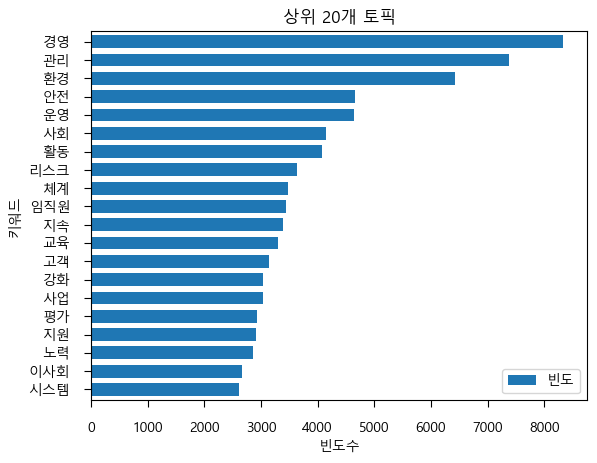

In [15]:
"""

빈도분석

"""

a = count_words(df)

# Colab 의 한글 폰트 설정
plt.rc('font', family='Malgun Gothic') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)


ax = a.head(20).plot(kind='barh', width=0.7)
ax.invert_yaxis()
ax.set(xlabel='빈도수', ylabel='키워드', title='상위 20개 토픽')
ax.tick_params(axis='x', which='major', pad=10, length=5, labelsize=10)
ax.tick_params(axis='y', which='major', pad=10, length=5, labelsize=10)
ax.title.set_fontsize(12) # 제목 폰트 크기 조절
# ax.figure.savefig('2020_2021_'+name+'_빈도분석.png')

In [ ]:
a[:50]

In [ ]:
a[100:150]

#### 2.2. 워드클라우드

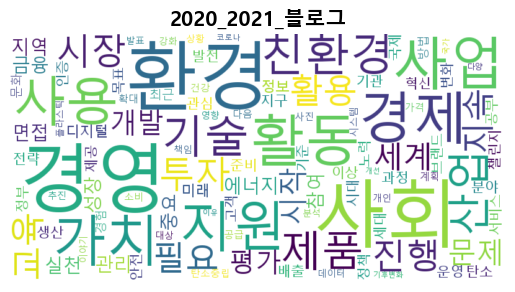

In [93]:
"""

워드 클라우드 생성

"""
import warnings
warnings.filterwarnings('ignore')

# 폰트경로
# path = '/usr/share/fonts/truetype/nanum/MalgunGothicc.ttf'  -- 코랩용
# wordcloud(path, word_freq, title=None, max_words=100, stopwords=None)
path = 'C:/Windows/Fonts/malgun.ttf'
wordcloud(path, name, a['빈도'], title='2020_2021_'+name)


#### 2.3. TF-IDF

In [32]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel


# 토큰화된 자료를 불러와 딕셔너리 생성
gensim_paragraphs = df['tokens']
dict_gensim_para = Dictionary(gensim_paragraphs)

# 문서의 빈도수 및 등장 문서 개수 설정
dict_gensim_para.filter_extremes(no_below=10, no_above=0.7)

## 사전 index 확인
# dict_gensim_para.token2id

# corpus(= BOW)
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]
# bow_gensim_para


#TF-IDF 생성
tfid_gensim_para = TfidfModel(bow_gensim_para)           # 가방 모델
vectors_gensim_para = tfid_gensim_para[bow_gensim_para]  # 가중치


# 단어별 가중치를 dictionary 형태로 변환(for wordcloud)
word_weights = {}
for doc in vectors_gensim_para:
    for word_id, weight in doc:
        word = dict_gensim_para[word_id]
        word_weights[word] = weight

### 3. 토픽모델링

#### 3.1. LDA(by gensim)

In [31]:
import itertools
token_list = df['tokens'].tolist()
token_list = list(itertools.chain(*token_list))
len(token_list)
b = set(token_list)
print(len(b))

12110


##### 3.1.1 lda 모델

In [54]:
## lda 자동 저장
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaModel
import pyLDAvis.gensim_models

def LDA_process(below_num, above_num, topic_num, dtype):
    
    # 토큰화된 자료를 불러와 딕셔너리 생성
    gensim_paragraphs = df['tokens']
    dict_gensim_para = Dictionary(gensim_paragraphs)

    # 문서의 빈도수 및 등장 문서 개수 설정
    dict_gensim_para.filter_extremes(no_below=below_num, no_above=above_num)

    ## 사전 index 확인
    # dict_gensim_para.token2id

    # corpus(= BOW)
    bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]
    # bow_gensim_para


    #TF-IDF 생성
    tfid_gensim_para = TfidfModel(bow_gensim_para)           # 가방 모델
    vectors_gensim_para = tfid_gensim_para[bow_gensim_para]  # 가중치
    
    
    lda_model = LdaMulticore(corpus = bow_gensim_para,
                             id2word = dict_gensim_para,
                             chunksize = 2000,
                             eta = 'auto',
                             iterations = 400,
                             num_topics = topic_num,
                             passes = 30,
                             eval_every = None,
                             random_state = 42) 
    
    
    # coh, per 계산
    lda_coherence = CoherenceModel(model = lda_model,
                               texts=gensim_paragraphs,
                               dictionary=dict_gensim_para,
                               coherence='c_v')
    coherence_score = lda_coherence.get_coherence()
    
    lda_perplexity = lda_model.log_perplexity(bow_gensim_para)    
    
    
    topics = lda_model.show_topics(num_topics=topic_num)        
    df_topics = pd.DataFrame(topics, columns=["topic", "words"])
    # 토픽 저장
    df_topics.to_excel('topic'+str(below_num)+"_"+str(above_num)+'_'+str(topic_num)+'.xlsx', encoding='utf-8-sig')


    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_gensim_para, dict_gensim_para)
    
    #작업내용 저장
    pyLDAvis.save_html(vis, dtype+str(below_num)+"_"+str(above_num)+'_'+str(topic_num)+'.html')
    
    print("no_below: %d, no_above: %d, n_topic: %d 분석완료. coherence_cv: %f, perplexity: %f" % (below_num, above_num, topic_num, coherence_score, lda_perplexity))

In [ ]:
num_list = [10, 15, 18, 21]

for i in tqdm(num_list):
    LDA_process(15, 0.5, i, '소셜미디어_2022_')

In [46]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# 토큰화된 자료를 불러와 딕셔너리 생성
gensim_paragraphs = df['tokens']
dict_gensim_para = Dictionary(gensim_paragraphs)

# 문서의 빈도수 및 등장 문서 개수 설정
dict_gensim_para.filter_extremes(no_below=15, no_above=0.5)

## 사전 index 확인
# dict_gensim_para.token2id

# corpus(= BOW)
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]
# bow_gensim_para


#TF-IDF 생성
tfid_gensim_para = TfidfModel(bow_gensim_para)           # 가방 모델
vectors_gensim_para = tfid_gensim_para[bow_gensim_para]  # 가중치

In [ ]:
print(len(dict_gensim_para))
g = dict_gensim_para.token2id
for k, v in g.items():
    print (k, v)

In [8]:
from gensim.models import LdaModel

lda_gensim_para = LdaModel(corpus = tqdm(bow_gensim_para),
                          id2word = dict_gensim_para,
                          chunksize = 2000,
                          eta = 'auto',
                          iterations = 400,
                          num_topics = 12,
                          passes = 30,
                          eval_every = None,
                          random_state = 42)


100%|█████████████████████████████████████████████████████████████████████████████| 4779/4779 [00:08<00:00, 532.84it/s]


##### 3.1.2 토픽 출력

In [96]:
lda_gensim_para.show_topics()        

[(9,
  '0.035*"경영" + 0.030*"사업" + 0.028*"지원" + 0.016*"혁신" + 0.016*"협력" + 0.014*"기관" + 0.013*"개발" + 0.013*"산업" + 0.013*"추진" + 0.011*"강화"'),
 (6,
  '0.056*"면접" + 0.030*"채용" + 0.020*"지원" + 0.019*"질문" + 0.019*"준비" + 0.017*"경험" + 0.016*"합격" + 0.015*"작성" + 0.015*"직무" + 0.012*"서류"'),
 (12,
  '0.080*"교육" + 0.026*"청년" + 0.023*"강의" + 0.022*"과정" + 0.017*"대학" + 0.017*"프로그램" + 0.015*"학교" + 0.015*"진행" + 0.014*"대학교" + 0.014*"학생"'),
 (16,
  '0.050*"에너지" + 0.039*"탄소" + 0.028*"배출" + 0.025*"탄소중립" + 0.013*"온실가스" + 0.012*"감축" + 0.011*"수소" + 0.011*"발전" + 0.011*"재생에너지" + 0.010*"녹색"'),
 (0,
  '0.037*"사용" + 0.014*"제품" + 0.011*"피부" + 0.011*"화장품" + 0.011*"식물" + 0.011*"탄생" + 0.009*"일반" + 0.008*"포장" + 0.008*"성분" + 0.007*"종이"'),
 (14,
  '0.032*"참여" + 0.021*"활동" + 0.021*"진행" + 0.020*"행사" + 0.016*"공모전" + 0.016*"전시" + 0.016*"콘텐츠" + 0.013*"서포터" + 0.013*"국제" + 0.013*"신청"'),
 (18,
  '0.046*"챌린지" + 0.033*"가치" + 0.030*"공부" + 0.019*"모닝" + 0.019*"월드" + 0.018*"디지털" + 0.017*"직업" + 0.014*"언서" + 0.014*"사회" + 0.013*"시작"'),
 (17,


In [126]:
# 토픽 다운로드
topics = lda_gensim_para.show_topics()        
df_topics = pd.DataFrame(topics, columns=["topic", "words"])
df_topics.to_excel('topic'+str(below_num)+"_"+str(above_num)+'_'+str(topic_num)+'.xlsx', encoding='utf-8-sig')



In [27]:
## 최적의 passes 수 산정
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

lda_para_model_p = []

for p in range(5, 61, 5):
# for p in range(1, 5):   
    lda_model = LdaMulticore(corpus=bow_gensim_para,
                             id2word=dict_gensim_para,
                             chunksize=2000,
                             eta='auto',
                             num_topics = 10,
                             passes = p,
                             eval_every=None,
                             random_state=42)
    
    lda_coherence = CoherenceModel(model = lda_model,
                                   texts=gensim_paragraphs,
                                   dictionary=dict_gensim_para,
                                   coherence='c_v')
    
    lda_perplexity = lda_model.log_perplexity(bow_gensim_para)
    
    lda_para_model_p.append((p, lda_coherence.get_coherence(), lda_perplexity))
                            
    
    print(lda_perplexity)
    print(lda_coherence.get_coherence())
    # print('\n')

result = pd.DataFrame(lda_para_model_p)

-6.345168805563912
0.4767075228408849
-6.283866649432158
0.5019567250673099
-6.270082074104678
0.5052903007790883
-6.264573814595432
0.5096493037221798
-6.261650583907802
0.5158570805730076
-6.259882018856053
0.5150934953176121
-6.258728022999034
0.5144643625629854
-6.257962845813618
0.5203421682351993
-6.257354273162297
0.5235196628414751
-6.256920459443403
0.5277769032214642
-6.256608352456475
0.5284279555923626
-6.256301892985688
0.5284279555923627


In [28]:
result = pd.DataFrame(lda_para_model_p, columns=['Number of passes', 'Coherence', 'Perplexity'],index=None)

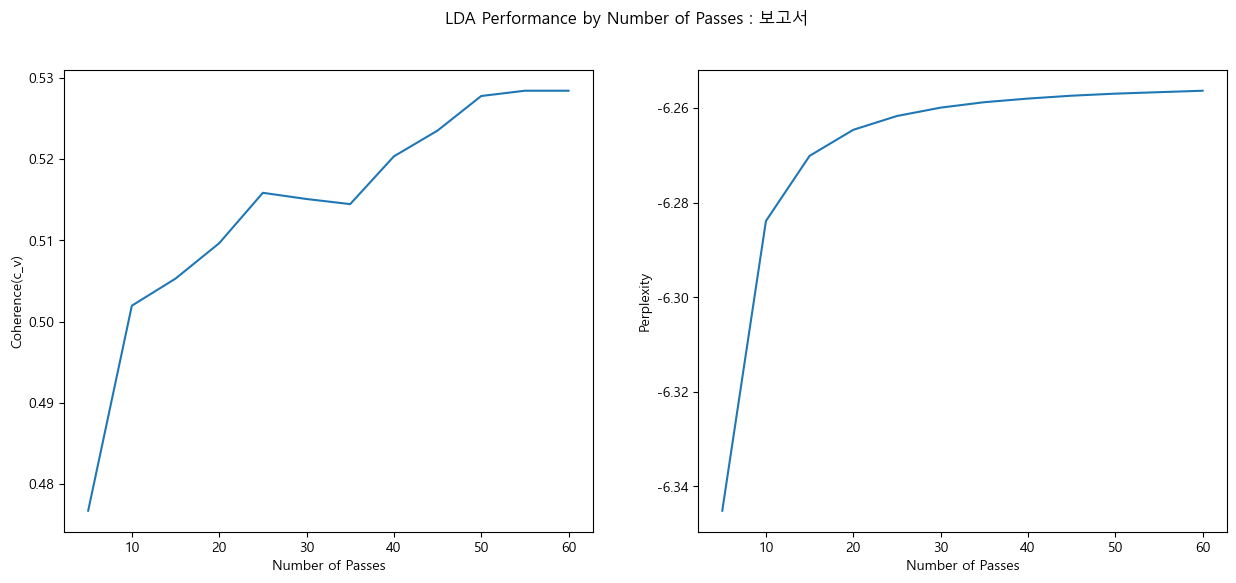

In [29]:
result_show= result.set_index('Number of passes')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
result_show['Coherence'].plot(ax=axes[0])
result_show['Perplexity'].plot(ax=axes[1])

axes[0].set_ylabel('Coherence(c_v)')
axes[1].set_ylabel('Perplexity')

axes[0].set_xlabel('Number of Passes')
axes[1].set_xlabel('Number of Passes')
fig.suptitle('LDA Performance by Number of Passes : 보고서')
fig.savefig('보고서_학습수_03_20.png')
plt.show()


##### 3.1.3 최적의 토픽 개수 탐색

In [47]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import numpy as np

lda_para_model_n = []

for n in tqdm(range(3, 34, 3)):
    lda_model = LdaMulticore(corpus=bow_gensim_para,
                             id2word=dict_gensim_para,
                             chunksize=2000,
                             eta='auto',
                             num_topics = n,
                             passes =30,
                             eval_every=None,
                             random_state=42)
    
    lda_coherence = CoherenceModel(model = lda_model,
                                   texts=gensim_paragraphs,
                                   dictionary=dict_gensim_para,
                                   coherence='c_v')

    lda_perplexity = lda_model.log_perplexity(bow_gensim_para)
    # lda_perplexity = np.exp(-1*lda_model.log_perplexity(bow_gensim_para))
    
    lda_para_model_n.append((n, lda_coherence.get_coherence(), lda_perplexity))
                            
    
    print(lda_perplexity)
    print(lda_coherence.get_coherence())
    print('\n\n')

result = pd.DataFrame(lda_para_model_n)

  9%|███████▍                                                                          | 1/11 [03:51<38:34, 231.47s/it]

-7.992031333832132
0.46161780906289174





 18%|██████████████▉                                                                   | 2/11 [07:45<34:57, 233.10s/it]

-7.863135478095494
0.521498696282876



-7.767638386654789


 27%|██████████████████████▎                                                           | 3/11 [11:46<31:33, 236.70s/it]

0.563491387978724



-7.734478457806772


 36%|█████████████████████████████▊                                                    | 4/11 [15:54<28:07, 241.13s/it]

0.5670459222952914



-7.6823927183904335


 45%|█████████████████████████████████████▎                                            | 5/11 [20:05<24:27, 244.59s/it]

0.5916144612395052



-7.6475576570477894


 55%|████████████████████████████████████████████▋                                     | 6/11 [24:21<20:42, 248.56s/it]

0.6028305513266519



-7.624705577031932


 64%|████████████████████████████████████████████████████▏                             | 7/11 [28:48<16:57, 254.49s/it]

0.5950660663843288



-7.623848324339023


 73%|███████████████████████████████████████████████████████████▋                      | 8/11 [33:21<13:00, 260.31s/it]

0.5715571705201677



-7.602993444247882


 82%|███████████████████████████████████████████████████████████████████               | 9/11 [38:11<08:59, 269.85s/it]

0.5698868071713831



-7.594251283833721


 91%|█████████████████████████████████████████████████████████████████████████▋       | 10/11 [43:01<04:35, 275.81s/it]

0.5785285373490776



-7.577362116608397


100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [47:57<00:00, 261.62s/it]

0.5700486592107318





In [48]:
name = 'social_2022_15_50_'

In [49]:
result = pd.DataFrame(lda_para_model_n, columns=['Number of Topic', 'Coherence', 'Perplexity'],index=None)
result.to_excel('coh_perp_'+name+'.xlsx', encoding='utf8')

C:\Users\user\anaconda3\envs\mecab\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_99936\1163350959.py:13: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.savefig('소셜미디어_2022_토픽수_15_50.png')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_99936\1163350959.py:13: UserWarning: Glyph 49500 (\N{HANGUL SYLLABLE SYEOL}) missing from current font.
  fig.savefig('소셜미디어_2022_토픽수_15_50.png')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_99936\1163350959.py:13: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.savefig('소셜미디어_2022_토픽수_15_50.png')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_99936\1163350959.py:13: UserWarning: Glyph 46356 (\N{HANGUL SYLLABLE DI}) missing from current font.
  fig.savefig('소셜미디어_2022_토픽수_15_50.png')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_99936\1163350959.py:13: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.savefig('소셜미디어_2022_토픽수_15_50.png')
C:

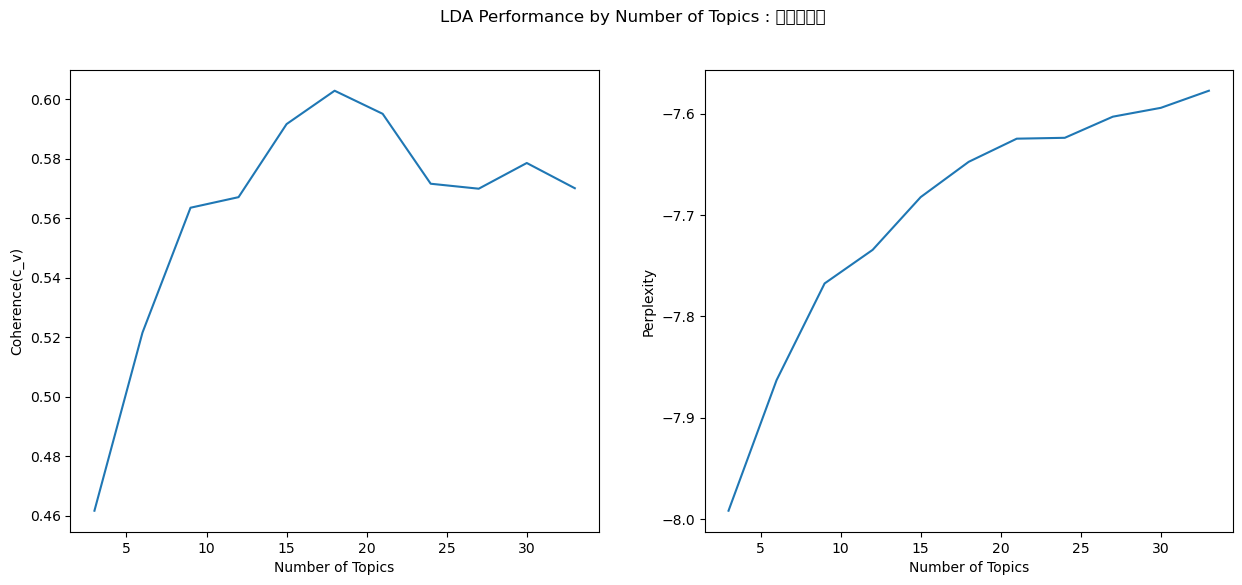

In [50]:
result_show= result.set_index('Number of Topic')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
result_show['Coherence'].plot(ax=axes[0])
result_show['Perplexity'].plot(ax=axes[1])

axes[0].set_ylabel('Coherence(c_v)')
axes[1].set_ylabel('Perplexity')

axes[0].set_xlabel('Number of Topics')
axes[1].set_xlabel('Number of Topics')
fig.suptitle('LDA Performance by Number of Topics : 소셜미디어')
fig.savefig('소셜미디어_2022_토픽수_15_50.png')
plt.show()

In [46]:
result_show

,Coherence,Perplexity
Number of Topic,,
5,0.302850,-6.751830
6,0.291232,-6.749672
7,0.280426,-6.743693
8,0.318871,-6.737485
9,0.332240,-6.756479
10,0.323027,-6.753632
11,0.329179,-6.752068
12,0.349211,-6.734683
13,0.367168,-6.733791


##### 3.1.? LDA 시각화

In [123]:
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_gensim_para, bow_gensim_para, dict_gensim_para)
pyLDAvis.display(vis)

C:\Users\User\anaconda3\envs\jh2\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [124]:
#작업내용 저장
pyLDAvis.save_html(vis, '보고서_10_50_21.html')

### 4. 네트워크분석

In [19]:
def get_top_words(model, num_words):
    result = []
    for i in range(model.num_topics):
        words = model.show_topic(i, num_words)
        result.append([word[0] for word in words])
    
    # 리스트 병합
    result = sum(result, [])
    return result

In [ ]:
word_list = get_top_words(lda_gensim_para, 5)
word_list

In [25]:
import networkx as nx

G = nx.Graph()   # undirected graph 생성
G.add_nodes_from(word_list)   # node 생성 (긱 토픽별 상위 단어 5개)

print(G.nodes()) # nodes
print(G.edges()) # edge

['임직원', '지원', '인재', '사회', '문화', '리스크', '관리', '정보', '보안', '정보보호', '지속', '가치', '환경', '성장', '교육', '협력사', '평가', '운영', '금융', '주주', '생명', '보호', '투자', '윤리', '거래', '공정', '준법', '제품', '개발', '기술', '친환경', '고객', '물질', '폐기물', '오염', '에너지', '배출', '온실가스', '감축', '기후변화', '품질', '시스템', '인증', '이사회', '위원회', '사외이사', '이사', '구성', '안전', '보건', '인권', '예방']
[]


In [29]:
text_list = df['text'].to_list()
len(text_list)

4779

In [ ]:
import itertools

for sentence in text_list:  # 각 문장을 element로 담고 있는 list
    
    
    tokenized_words = ddd
    selected_words = []
    
    for word in tokenized_words:
        if word in word_list:
            selected_words.append(word)
    selected_words = set(selected_words)   # 중복을 제거하기 위해 set(집합자료형)으로 변환
    

    for pair in list(itertools.combinations(list(selected_words), 2)):  
                    # itertools.combinations: selected_words 리스트에서 2개씩 골라 조합을 만들어준다
        if pair in G.edges(): 
            weight = G[pair[0]][pair[1]]['weight']
            weight += 1
            G[pair[0]][pair[1]]['weight'] = weight    
        else:
            G.add_edge(pair[0], pair[1], weight=1)


# 생성된 edge 확인해보기
print(nx.get_edge_attributes(G, 'weight'))